![banner](./images/knobs.jpeg)

# Recommendation System for DJ'ing Electronic Music
***
Author: [Paul Lindquist](https://www.linkedin.com/in/paul-lindquist/)

## Overview
***
TBD

## Objective
***
TBD

## Data
***
TBD

## Methods
***
TBD

## Library Imports
***

In [227]:
# Libraries and packages
import pandas as pd
from tqdm import tqdm
import time
import requests
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Spotify authorization .py
import spotify_authorization

## Manual API Calls to Spotify Web API
***
Registered a Spotify Developer account to get a Client ID and Client Secret. Used this to browse genres within Spotify's "categories."

In [11]:
CLIENT_ID = '4eb9684aba474efa92f55be38917497e'
CLIENT_SECRET = '80f447a4ac9a40ef99dac84fc345e3b9'

AUTH_URL = 'https://accounts.spotify.com/api/token'

auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
})

auth_response_data = auth_response.json()

access_token = auth_response_data['access_token']

headers = {
    'Authorization': 'Bearer {token}'.format(token=access_token)
}

BASE_URL = 'https://api.spotify.com/v1/'

categories = 'browse/categories'

r = requests.get(BASE_URL + categories, headers=headers)

r = r.json()
r

{'categories': {'href': 'https://api.spotify.com/v1/browse/categories?offset=0&limit=20',
  'items': [{'href': 'https://api.spotify.com/v1/browse/categories/toplists',
    'icons': [{'height': 275,
      'url': 'https://t.scdn.co/media/derived/toplists_11160599e6a04ac5d6f2757f5511778f_0_0_275_275.jpg',
      'width': 275}],
    'id': 'toplists',
    'name': 'Top Lists'},
   {'href': 'https://api.spotify.com/v1/browse/categories/hiphop',
    'icons': [{'height': 274,
      'url': 'https://t.scdn.co/media/original/hip-274_0a661854d61e29eace5fe63f73495e68_274x274.jpg',
      'width': 274}],
    'id': 'hiphop',
    'name': 'Hip-Hop'},
   {'href': 'https://api.spotify.com/v1/browse/categories/pop',
    'icons': [{'height': 274,
      'url': 'https://t.scdn.co/media/derived/pop-274x274_447148649685019f5e2a03a39e78ba52_0_0_274_274.jpg',
      'width': 274}],
    'id': 'pop',
    'name': 'Pop'},
   {'href': 'https://api.spotify.com/v1/browse/categories/country',
    'icons': [{'height': None,


In [12]:
BASE_URL = 'https://api.spotify.com/v1/'

dj_music = 'browse/categories/edm_dance'

r = requests.get(BASE_URL + dj_music, headers=headers)

r = r.json()
r

{'href': 'https://api.spotify.com/v1/browse/categories/edm_dance',
 'icons': [{'height': 274,
   'url': 'https://t.scdn.co/media/derived/edm-274x274_0ef612604200a9c14995432994455a6d_0_0_274_274.jpg',
   'width': 274}],
 'id': 'edm_dance',
 'name': 'Dance/Electronic'}

## Data Imports, Creation, Concatenation and Cleaning
***

### Spotify API Calls

In [13]:
# Authorize Spotify API access
sp = spotify_authorization.authorize()

In [14]:
# Get a list of all Spotify genres to narrow down to electronic music-specific
print(sp.recommendation_genre_seeds())

['acoustic', 'afrobeat', 'alt-rock', 'alternative', 'ambient', 'anime', 'black-metal', 'bluegrass', 'blues', 'bossanova', 'brazil', 'breakbeat', 'british', 'cantopop', 'chicago-house', 'children', 'chill', 'classical', 'club', 'comedy', 'country', 'dance', 'dancehall', 'death-metal', 'deep-house', 'detroit-techno', 'disco', 'disney', 'drum-and-bass', 'dub', 'dubstep', 'edm', 'electro', 'electronic', 'emo', 'folk', 'forro', 'french', 'funk', 'garage', 'german', 'gospel', 'goth', 'grindcore', 'groove', 'grunge', 'guitar', 'happy', 'hard-rock', 'hardcore', 'hardstyle', 'heavy-metal', 'hip-hop', 'holidays', 'honky-tonk', 'house', 'idm', 'indian', 'indie', 'indie-pop', 'industrial', 'iranian', 'j-dance', 'j-idol', 'j-pop', 'j-rock', 'jazz', 'k-pop', 'kids', 'latin', 'latino', 'malay', 'mandopop', 'metal', 'metal-misc', 'metalcore', 'minimal-techno', 'movies', 'mpb', 'new-age', 'new-release', 'opera', 'pagode', 'party', 'philippines-opm', 'piano', 'pop', 'pop-film', 'post-dubstep', 'power-po

In [15]:
# Set genres for electronic music
genres = ['breakbeat', 'chicago-house', 'club', 'dance', 'dancehall',
          'deep-house', 'detroit-techno', 'disco', 'drum-and-bass', 'dub',
          'dubstep', 'edm', 'electro', 'electronic', 'funk', 'garage',
          'hardstyle', 'house', 'idm', 'indie-pop', 'industrial', 'j-dance',
          'minimal-techo', 'new-release', 'party', 'post-dubstep',
          'progressive-house', 'synth-pop', 'techno', 'trance', 'trip-hop',
          'work-out']

Write a function that creates a dictionary of 100 songs for each designated genre listed above

In [16]:
def spotify_dataset_by_genres(genre_list):
    
    # Set number of recommendations per genre (100 max according to Spotify
    # API documentation)
    n_recs = 100
    
    # Create a dictionary with desired info to extract from each genre
    data_dict = {'artist_name': [], 'track_name': [], 'genre': [], 'tempo': [],
                 'danceability': [], 'energy': [], 'valence': [], 'id': []}
    
    # Get recs for every genre
    for g in genre_list:
        
        # Get n recommendations
        recs = sp.recommendations(genres=[g], limit=n_recs)

        # JSON-like string to dictionary
        recs = eval(recs.json().replace('null', '-999').replace('false', 'False').replace('true', 'True'))['tracks']

        # Iterate through & extract data from each track
        for track in recs:

            # Metadata
            track_meta = sp.track(track['id'])
            data_dict['track_name'].append(track_meta.name)
            data_dict['artist_name'].append(track_meta.album.artists[0].name)

            # ID and genre
            data_dict['genre'].append(g)
            data_dict['id'].append(track['id'])

            # Track features
            track_features = sp.track_audio_features(track['id'])
            data_dict['tempo'].append(track_features.tempo)
            data_dict['danceability'].append(track_features.danceability)
            data_dict['energy'].append(track_features.energy)
            data_dict['valence'].append(track_features.valence)

            # Wait .2 seconds per track so as not to overload API
            time.sleep(0.2)

    # Store data in DataFrame
    df = pd.DataFrame(data_dict)

    # Drop duplicates
    df.drop_duplicates(subset='id', keep='first', inplace=True)

    return df

### Dataset Build-Out

#### *Below is a sample function call used to build datasets. I kept getting myriad of ReadTimeout, Bad Gateway, etc. errors related to the API calls during multiple DataFrame creation so I unfortanetly had to resort to doing so manually, one at a time.*

In [ ]:
spotify_1 = spotify_dataset_by_genres(genres)

#### *The code blocks below were used to manually create datasets. Due to being computationally expensive, they've been commented out.*

In [ ]:
# spotify_2 = spotify_dataset_by_genres(genres)

In [ ]:
# spotify_3 = spotify_dataset_by_genres(genres)

In [ ]:
# spotify_1_thru_3 = pd.concat([spotify_1, spotify_2, spotify_3],
#                             ignore_index=True)

In [ ]:
# spotify_1_thru_3 = spotify_1_thru_3.drop_duplicates(subset='id', keep='first')

In [ ]:
# spotify_1_thru_3.to_csv('spotify_1_thru_3.csv', index=False)

In [ ]:
# spotify_4 = spotify_dataset_by_genres(genres)

In [ ]:
# spotify_5 = spotify_dataset_by_genres(genres)

In [ ]:
# spotify_6 = spotify_dataset_by_genres(genres)

In [ ]:
# spotify_4_thru_6 = pd.concat([spotify_4, spotify_5, spotify_6],
#                             ignore_index=True)
# spotify_4_thru_6 = spotify_4_thru_6.drop_duplicates(subset='id', keep='first')
# spotify_4_thru_6.to_csv('spotify_4_thru_6.csv', index=False)

In [ ]:
# spotify_7 = spotify_dataset_by_genres(genres)

In [ ]:
# spotify_8 = spotify_dataset_by_genres(genres)

In [ ]:
# spotify_9 = spotify_dataset_by_genres(genres)

In [ ]:
# spotify_7_thru_9 = pd.concat([spotify_7, spotify_8, spotify_9],
#                             ignore_index=True)
# spotify_7_thru_9 = spotify_7_thru_9.drop_duplicates(subset='id', keep='first')
# spotify_7_thru_9.to_csv('spotify_7_thru_9.csv', index=False)

In [ ]:
# spotify_10 = spotify_dataset_by_genres(genres)

In [ ]:
# spotify_11 = spotify_dataset_by_genres(genres)

In [ ]:
# spotify_12 = spotify_dataset_by_genres(genres)

In [ ]:
# spotify_10_thru_12 = pd.concat([spotify_10, spotify_11, spotify_12],
#                             ignore_index=True)
# spotify_10_thru_12 = spotify_10_thru_12.drop_duplicates(subset='id', keep='first')
# spotify_10_thru_12.to_csv('spotify_10_thru_12.csv', index=False)

In [ ]:
# spotify_13 = spotify_dataset_by_genres(genres)

In [ ]:
# spotify_14 = spotify_dataset_by_genres(genres)

In [ ]:
# spotify_13_thru_14 = pd.concat([spotify_13, spotify_14],
#                             ignore_index=True)
# spotify_13_thru_14 = spotify_13_thru_14.drop_duplicates(subset='id', keep='first')
# spotify_13_thru_14.to_csv('spotify_13_thru_14.csv', index=False)

### Dataset Imports and Builds

In [196]:
genres_set_1 = pd.read_csv('./data/spotify_1_thru_3.csv')
genres_set_2 = pd.read_csv('./data/spotify_4_thru_6.csv')
genres_set_3 = pd.read_csv('./data/spotify_7_thru_9.csv')
genres_set_4 = pd.read_csv('./data/spotify_10_thru_12.csv')
genres_set_5 = pd.read_csv('./data/spotify_13_thru_14.csv')

sp_more_genres = pd.read_csv('./data/songs_all_genres_trunc.csv')

edm_only_set = pd.read_excel('./data/spotify_edm_only.xlsx')

more_edm = pd.read_csv('./data/more_electronic.csv')

In [197]:
sp_recommended = pd.concat([genres_set_1, genres_set_2,
                           genres_set_3, genres_set_4,
                           genres_set_5], ignore_index=True)

sp_recommended = sp_recommended.drop_duplicates(subset='id', keep='first')

sp_recommended

,artist_name,track_name,genre,tempo,danceability,energy,valence,id
0,Various Artists,Dun Proppa,breakbeat,103.995,0.651,0.977,0.781,6a5aQlAAdgObJ3KhM9NRZW
1,Various Artists,Who's Making Love,breakbeat,102.052,0.709,0.390,0.815,42UHQGcpq8oxAujCQpxGII
2,The Future Sound Of London,Papua New Guinea,breakbeat,124.870,0.550,0.575,0.371,1r1OeKQ1y7Q20A6ekUXtYq
3,Various Artists,"Don't Call Me Nigger, Whitey",breakbeat,183.978,0.602,0.921,0.512,56r13tQH07EPshIRvW9eXy
4,DJ Andy Smith,The Choice Is Yours,breakbeat,101.397,0.879,0.847,0.711,6281LdA2cVFwVM0xC5cqA8
...,...,...,...,...,...,...,...,...
26016,Various Artists,We Own It (Fast & Furious),work-out,171.966,0.554,0.899,0.552,5DD9jE8Z3LvpVn2TxknJyX
26026,Madcon,Beggin - Original Version,work-out,129.041,0.715,0.796,0.431,7eXrGBrl1mBKhxlWX0IoOQ
26027,Mac Miller,Donald Trump,work-out,162.994,0.636,0.901,0.836,3uulVrxiI7iLTjOBZsaiF8
26031,Kim Cesarion,Undressed,work-out,119.942,0.812,0.853,0.646,0gpoeZamw0GIJllSNTzvIB


In [198]:
sp_recommended.rename(columns={'artist_name': 'Artists',
                               'track_name': 'Song_Title',
                               'genre': 'Genre',
                               'tempo': 'Tempo',
                               'danceability': 'Danceability',
                               'energy': 'Energy',
                               'valence': 'Valence',
                               'id': 'ID'}, inplace=True)
sp_recommended

,Artists,Song_Title,Genre,Tempo,Danceability,Energy,Valence,ID
0,Various Artists,Dun Proppa,breakbeat,103.995,0.651,0.977,0.781,6a5aQlAAdgObJ3KhM9NRZW
1,Various Artists,Who's Making Love,breakbeat,102.052,0.709,0.390,0.815,42UHQGcpq8oxAujCQpxGII
2,The Future Sound Of London,Papua New Guinea,breakbeat,124.870,0.550,0.575,0.371,1r1OeKQ1y7Q20A6ekUXtYq
3,Various Artists,"Don't Call Me Nigger, Whitey",breakbeat,183.978,0.602,0.921,0.512,56r13tQH07EPshIRvW9eXy
4,DJ Andy Smith,The Choice Is Yours,breakbeat,101.397,0.879,0.847,0.711,6281LdA2cVFwVM0xC5cqA8
...,...,...,...,...,...,...,...,...
26016,Various Artists,We Own It (Fast & Furious),work-out,171.966,0.554,0.899,0.552,5DD9jE8Z3LvpVn2TxknJyX
26026,Madcon,Beggin - Original Version,work-out,129.041,0.715,0.796,0.431,7eXrGBrl1mBKhxlWX0IoOQ
26027,Mac Miller,Donald Trump,work-out,162.994,0.636,0.901,0.836,3uulVrxiI7iLTjOBZsaiF8
26031,Kim Cesarion,Undressed,work-out,119.942,0.812,0.853,0.646,0gpoeZamw0GIJllSNTzvIB


In [199]:
sp_more_genres = sp_more_genres.drop_duplicates(subset='Id', keep='first')

sp_more_genres

,Name,Id,Artists,Artists_Id,Release,Duration,Genre,Danceability,Energy,Key,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valeance,Tempo
0,Hero,29p6UW08MXzwj9thWBW3uF,"['Afrojack', 'David Guetta']","['4D75GcNG95ebPtNvoNVXhz', '1Cs0zKBU1kc0i8ypK3...",4/30/21,171840,edm,0.713,0.772,2,-5.032,0.0313,0.157000,0.0000,0.1530,0.5230,125.001
1,Chasing Stars (feat. James Bay),6y6xhAgZjvxy5kR5rigpY3,"['Alesso', 'Marshmello', 'James Bay']","['4AVFqumd2ogHFlRbKIjp1t', '64KEffDW9EtZ1y2vBY...",8/20/21,170457,edm,0.594,0.640,10,-6.865,0.0330,0.016900,0.0000,0.1350,0.4920,92.871
2,Gotta Be You,2Q8fFORnsDE6I3RNvSLXSf,"['NERVO', 'Carla Monroe']","['4j5KBTO4tk7up54ZirNGvK', '4S9LNSZusH3XflT3g3...",1/8/21,149032,edm,0.642,0.869,6,-5.271,0.0452,0.252000,0.0288,0.0708,0.3760,123.910
3,Okay,71H8k9qe7DersxR6KyhUnI,"['Nicky Romero', 'MARF', 'Wulf']","['5ChF3i92IPZHduM7jN3dpg', '6y1eDna5tYFgcvKyGh...",7/23/21,151312,edm,0.513,0.836,2,-3.781,0.0579,0.046300,0.0000,0.1280,0.3040,124.964
4,Get Low,3oZoXyU0SkDldgS7AcN4y4,"['Dillon Francis', 'DJ Snake']","['5R3Hr2cnCCjt220Jmt2xLf', '540vIaP2JwjQb9dm3a...",10/22/14,212773,edm,0.674,0.932,11,-4.424,0.0859,0.028200,0.7100,0.6840,0.7280,101.033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4160,Aiguilhe,2K0uZFmADV2hpSvJITvGoL,['Joris Delacroix'],['3HRRzIZNQFus3xlUx2xKy1'],11/19/20,289268,deep house,0.687,0.892,4,-7.473,0.0613,0.205000,0.8140,0.0636,0.1970,123.026
4161,Disco,707SqZpNC3qGHAP0FSQjqL,['Krueger & Leu'],['1K5AMz99qCSXYrMQJIUGw2'],5/21/13,384823,deep house,0.872,0.608,7,-10.852,0.0458,0.000779,0.6200,0.0861,0.4910,121.015
4163,Can I,3qavQewlgidBuYHrJe3Qqb,['Britta Arnold'],['7JpBTUqubY86KynSJr28RN'],3/19/21,511990,deep house,0.809,0.667,7,-7.797,0.0565,0.000623,0.8330,0.0920,0.0325,120.019
4164,By Defection,2auhKxSJCfnsaOVxFoF3uA,['Dixie Yure'],['63Hs70Er0FXT7oVFaiP3Xb'],4/27/10,506468,deep house,0.927,0.513,5,-8.091,0.0646,0.011700,0.7900,0.1680,0.2420,124.019


In [200]:
edm_only_set = edm_only_set.drop_duplicates(subset='id', keep='first')

edm_only_set

,Genre,Title,Album_cover_link,Artist,duration_ms,explicit,id,popularity,release_date,release_date_precision,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,edm,Hero,https://i.scdn.co/image/ab67616d0000b27368c134...,Afrojack,171840,False,29p6UW08MXzwj9thWBW3uF,73,2021-04-30,day,...,2,-5.032,1,0.0313,0.15700,0.000000,0.1530,0.523,125.001,4
1,edm,Real Love (feat. Aleyna Tilki),https://i.scdn.co/image/ab67616d0000b2738fe23c...,Dillon Francis,135265,False,7BxIvkfVSgoUUlDcBVff61,48,2021-10-05,day,...,10,-4.313,0,0.0685,0.04960,0.000085,0.0522,0.555,124.012,4
2,edm,Gotta Be You,https://i.scdn.co/image/ab67616d0000b27329204e...,NERVO,149032,False,2Q8fFORnsDE6I3RNvSLXSf,67,2021-01-08,day,...,6,-5.271,0,0.0452,0.25200,0.028800,0.0708,0.376,123.910,4
3,edm,Okay,https://i.scdn.co/image/ab67616d0000b2737dd8c5...,Nicky Romero,151312,False,1muUz481pBOMzJ9De3NS6e,33,2021-09-10,day,...,2,-3.781,1,0.0579,0.04630,0.000000,0.1280,0.304,124.964,4
4,edm,Worst Case,https://i.scdn.co/image/ab67616d0000b273380a16...,3LAU,178048,False,3zbbRebB1rzlXJgq7Ufn8V,62,2021-10-08,day,...,6,-5.775,0,0.0339,0.00463,0.034700,0.2050,0.177,122.975,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,edm,Break Me,https://i.scdn.co/image/ab67616d0000b273c3bbe6...,Trivecta,222631,False,3cjkfbF4rgqymxtRn7Iv15,43,2017-07-03,day,...,11,-4.150,0,0.1680,0.04980,0.000003,0.3460,0.463,75.995,4
952,edm,Shiawase - VIP,https://i.scdn.co/image/ab67616d0000b273d1dcf9...,Dion Timmer,181750,False,4mTLnLuHoGhA2xd595OMg1,47,2020-09-09,day,...,8,-0.563,1,0.1540,0.00612,0.000176,0.6650,0.500,150.096,4
953,edm,Left Behinds - Radio Edit,https://i.scdn.co/image/ab67616d0000b2737fff2e...,Paris Blohm,180014,False,2Lmk4VmhPzw6fw3kvKmmUe,23,2014-08-04,day,...,8,-4.051,0,0.1520,0.00185,0.033100,0.1430,0.155,128.027,4
954,edm,R.E.A.L,https://i.scdn.co/image/ab67616d0000b273389ba0...,Dombresky,183095,False,1mK6vQxrBu7tStp3b8G2Z9,53,2021-10-15,day,...,0,-3.240,1,0.0741,0.00106,0.834000,0.0348,0.768,126.003,4


In [201]:
more_edm = more_edm.drop_duplicates(subset='Uri', keep='first')

more_edm

,Uri,Title,Artist,Genre,danceability,energy,valence,tempo
0,5xhJmd0I15jFcEdqxfCzKk,it wont kill ya,The Chainsmokers - Louane,dance pop,0.572,0.530,0.120,170.138
1,0wJJhRgdHhT93Z3iWdMB0T,hymn,Kesha,dance pop,0.488,0.538,0.380,67.037
2,0kN8xEmgMW9mh7UmDYHlJP,versace on the floor,Bruno Mars,dance pop,0.578,0.574,0.301,174.152
3,4PkIDTPGedm0enzdvilLNd,sixteen,Ellie Goulding,dance pop,0.669,0.801,0.541,109.919
4,2qqZ5fOGuNvYVzgPFDLQ4l,marys boy child / oh my lord,Boney M.,disco,0.781,0.718,0.925,112.542
...,...,...,...,...,...,...,...,...
1119,4Sib57MmYGJzSvkW84jTwh,me!,Taylor Swift - Brendon Urie,dance pop,0.614,0.839,0.657,182.123
1120,4iyH6JZBZjk3htdJdZ6r51,ruin the friendship,Demi Lovato,dance pop,0.772,0.459,0.537,78.019
1121,1rIKgCH4H52lrvDcz50hS8,lush life,Zara Larsson,dance pop,0.694,0.712,0.799,98.022
1122,6f3Slt0GbA2bPZlz0aIFXN,the business,Tiësto,big room,0.798,0.620,0.235,120.031


### Data Cleaning

In [202]:
cols_order = ['Song_Title', 'Artists', 'Genre', 'Tempo', 'Danceability',
            'Energy', 'Valence', 'ID']

In [203]:
sp_recommended = sp_recommended[cols_order]
sp_recommended

,Song_Title,Artists,Genre,Tempo,Danceability,Energy,Valence,ID
0,Dun Proppa,Various Artists,breakbeat,103.995,0.651,0.977,0.781,6a5aQlAAdgObJ3KhM9NRZW
1,Who's Making Love,Various Artists,breakbeat,102.052,0.709,0.390,0.815,42UHQGcpq8oxAujCQpxGII
2,Papua New Guinea,The Future Sound Of London,breakbeat,124.870,0.550,0.575,0.371,1r1OeKQ1y7Q20A6ekUXtYq
3,"Don't Call Me Nigger, Whitey",Various Artists,breakbeat,183.978,0.602,0.921,0.512,56r13tQH07EPshIRvW9eXy
4,The Choice Is Yours,DJ Andy Smith,breakbeat,101.397,0.879,0.847,0.711,6281LdA2cVFwVM0xC5cqA8
...,...,...,...,...,...,...,...,...
26016,We Own It (Fast & Furious),Various Artists,work-out,171.966,0.554,0.899,0.552,5DD9jE8Z3LvpVn2TxknJyX
26026,Beggin - Original Version,Madcon,work-out,129.041,0.715,0.796,0.431,7eXrGBrl1mBKhxlWX0IoOQ
26027,Donald Trump,Mac Miller,work-out,162.994,0.636,0.901,0.836,3uulVrxiI7iLTjOBZsaiF8
26031,Undressed,Kim Cesarion,work-out,119.942,0.812,0.853,0.646,0gpoeZamw0GIJllSNTzvIB


In [204]:
edm_only_set.columns

Index(['Genre', 'Title', 'Album_cover_link', 'Artist', 'duration_ms',
       'explicit', 'id', 'popularity', 'release_date',
       'release_date_precision', 'total_tracks', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature'],
      dtype='object')

In [205]:
drop_cols = ['Album_cover_link', 'duration_ms', 'explicit', 'popularity',
            'release_date', 'release_date_precision', 'total_tracks',
            'key', 'loudness', 'mode', 'speechiness', 'acousticness',
            'instrumentalness', 'liveness', 'time_signature']

In [206]:
edm_only_set.drop(columns=drop_cols, inplace=True)
edm_only_set

,Genre,Title,Artist,id,danceability,energy,valence,tempo
0,edm,Hero,Afrojack,29p6UW08MXzwj9thWBW3uF,0.713,0.772,0.523,125.001
1,edm,Real Love (feat. Aleyna Tilki),Dillon Francis,7BxIvkfVSgoUUlDcBVff61,0.738,0.793,0.555,124.012
2,edm,Gotta Be You,NERVO,2Q8fFORnsDE6I3RNvSLXSf,0.642,0.869,0.376,123.910
3,edm,Okay,Nicky Romero,1muUz481pBOMzJ9De3NS6e,0.513,0.836,0.304,124.964
4,edm,Worst Case,3LAU,3zbbRebB1rzlXJgq7Ufn8V,0.629,0.809,0.177,122.975
...,...,...,...,...,...,...,...,...
951,edm,Break Me,Trivecta,3cjkfbF4rgqymxtRn7Iv15,0.407,0.885,0.463,75.995
952,edm,Shiawase - VIP,Dion Timmer,4mTLnLuHoGhA2xd595OMg1,0.557,0.980,0.500,150.096
953,edm,Left Behinds - Radio Edit,Paris Blohm,2Lmk4VmhPzw6fw3kvKmmUe,0.488,0.957,0.155,128.027
954,edm,R.E.A.L,Dombresky,1mK6vQxrBu7tStp3b8G2Z9,0.800,0.984,0.768,126.003


In [207]:
edm_only_set.rename(columns={'Artist': 'Artists',
                            'Title': 'Song_Title',
                            'tempo': 'Tempo',
                            'danceability': 'Danceability',
                            'energy': 'Energy',
                            'valence': 'Valence',
                            'id': 'ID'}, inplace=True)

edm_only = edm_only_set[cols_order]

edm_only

,Song_Title,Artists,Genre,Tempo,Danceability,Energy,Valence,ID
0,Hero,Afrojack,edm,125.001,0.713,0.772,0.523,29p6UW08MXzwj9thWBW3uF
1,Real Love (feat. Aleyna Tilki),Dillon Francis,edm,124.012,0.738,0.793,0.555,7BxIvkfVSgoUUlDcBVff61
2,Gotta Be You,NERVO,edm,123.910,0.642,0.869,0.376,2Q8fFORnsDE6I3RNvSLXSf
3,Okay,Nicky Romero,edm,124.964,0.513,0.836,0.304,1muUz481pBOMzJ9De3NS6e
4,Worst Case,3LAU,edm,122.975,0.629,0.809,0.177,3zbbRebB1rzlXJgq7Ufn8V
...,...,...,...,...,...,...,...,...
951,Break Me,Trivecta,edm,75.995,0.407,0.885,0.463,3cjkfbF4rgqymxtRn7Iv15
952,Shiawase - VIP,Dion Timmer,edm,150.096,0.557,0.980,0.500,4mTLnLuHoGhA2xd595OMg1
953,Left Behinds - Radio Edit,Paris Blohm,edm,128.027,0.488,0.957,0.155,2Lmk4VmhPzw6fw3kvKmmUe
954,R.E.A.L,Dombresky,edm,126.003,0.800,0.984,0.768,1mK6vQxrBu7tStp3b8G2Z9


In [208]:
more_edm.rename(columns={'Artist': 'Artists',
                        'Title': 'Song_Title',
                        'tempo': 'Tempo',
                        'danceability': 'Danceability',
                        'energy': 'Energy',
                        'valence': 'Valence',
                        'Uri': 'ID'}, inplace=True)

more_edm = more_edm[cols_order]

more_edm

,Song_Title,Artists,Genre,Tempo,Danceability,Energy,Valence,ID
0,it wont kill ya,The Chainsmokers - Louane,dance pop,170.138,0.572,0.530,0.120,5xhJmd0I15jFcEdqxfCzKk
1,hymn,Kesha,dance pop,67.037,0.488,0.538,0.380,0wJJhRgdHhT93Z3iWdMB0T
2,versace on the floor,Bruno Mars,dance pop,174.152,0.578,0.574,0.301,0kN8xEmgMW9mh7UmDYHlJP
3,sixteen,Ellie Goulding,dance pop,109.919,0.669,0.801,0.541,4PkIDTPGedm0enzdvilLNd
4,marys boy child / oh my lord,Boney M.,disco,112.542,0.781,0.718,0.925,2qqZ5fOGuNvYVzgPFDLQ4l
...,...,...,...,...,...,...,...,...
1119,me!,Taylor Swift - Brendon Urie,dance pop,182.123,0.614,0.839,0.657,4Sib57MmYGJzSvkW84jTwh
1120,ruin the friendship,Demi Lovato,dance pop,78.019,0.772,0.459,0.537,4iyH6JZBZjk3htdJdZ6r51
1121,lush life,Zara Larsson,dance pop,98.022,0.694,0.712,0.799,1rIKgCH4H52lrvDcz50hS8
1122,the business,Tiësto,big room,120.031,0.798,0.620,0.235,6f3Slt0GbA2bPZlz0aIFXN


In [209]:
drop_cols = ['Artists_Id', 'Release', 'Duration', 'Key', 'Loudness',
            'Speechiness', 'Acousticness', 'Instrumentalness',
            'Liveness']

In [210]:
sp_more_genres.drop(columns=drop_cols, inplace=True)
sp_more_genres

,Name,Id,Artists,Genre,Danceability,Energy,Valeance,Tempo
0,Hero,29p6UW08MXzwj9thWBW3uF,"['Afrojack', 'David Guetta']",edm,0.713,0.772,0.5230,125.001
1,Chasing Stars (feat. James Bay),6y6xhAgZjvxy5kR5rigpY3,"['Alesso', 'Marshmello', 'James Bay']",edm,0.594,0.640,0.4920,92.871
2,Gotta Be You,2Q8fFORnsDE6I3RNvSLXSf,"['NERVO', 'Carla Monroe']",edm,0.642,0.869,0.3760,123.910
3,Okay,71H8k9qe7DersxR6KyhUnI,"['Nicky Romero', 'MARF', 'Wulf']",edm,0.513,0.836,0.3040,124.964
4,Get Low,3oZoXyU0SkDldgS7AcN4y4,"['Dillon Francis', 'DJ Snake']",edm,0.674,0.932,0.7280,101.033
...,...,...,...,...,...,...,...,...
4160,Aiguilhe,2K0uZFmADV2hpSvJITvGoL,['Joris Delacroix'],deep house,0.687,0.892,0.1970,123.026
4161,Disco,707SqZpNC3qGHAP0FSQjqL,['Krueger & Leu'],deep house,0.872,0.608,0.4910,121.015
4163,Can I,3qavQewlgidBuYHrJe3Qqb,['Britta Arnold'],deep house,0.809,0.667,0.0325,120.019
4164,By Defection,2auhKxSJCfnsaOVxFoF3uA,['Dixie Yure'],deep house,0.927,0.513,0.2420,124.019


In [211]:
sp_more_genres.rename(columns={'Name': 'Song_Title', 'Id': 'ID',
                               'Valeance': 'Valence'}, inplace=True)
sp_more_genres

,Song_Title,ID,Artists,Genre,Danceability,Energy,Valence,Tempo
0,Hero,29p6UW08MXzwj9thWBW3uF,"['Afrojack', 'David Guetta']",edm,0.713,0.772,0.5230,125.001
1,Chasing Stars (feat. James Bay),6y6xhAgZjvxy5kR5rigpY3,"['Alesso', 'Marshmello', 'James Bay']",edm,0.594,0.640,0.4920,92.871
2,Gotta Be You,2Q8fFORnsDE6I3RNvSLXSf,"['NERVO', 'Carla Monroe']",edm,0.642,0.869,0.3760,123.910
3,Okay,71H8k9qe7DersxR6KyhUnI,"['Nicky Romero', 'MARF', 'Wulf']",edm,0.513,0.836,0.3040,124.964
4,Get Low,3oZoXyU0SkDldgS7AcN4y4,"['Dillon Francis', 'DJ Snake']",edm,0.674,0.932,0.7280,101.033
...,...,...,...,...,...,...,...,...
4160,Aiguilhe,2K0uZFmADV2hpSvJITvGoL,['Joris Delacroix'],deep house,0.687,0.892,0.1970,123.026
4161,Disco,707SqZpNC3qGHAP0FSQjqL,['Krueger & Leu'],deep house,0.872,0.608,0.4910,121.015
4163,Can I,3qavQewlgidBuYHrJe3Qqb,['Britta Arnold'],deep house,0.809,0.667,0.0325,120.019
4164,By Defection,2auhKxSJCfnsaOVxFoF3uA,['Dixie Yure'],deep house,0.927,0.513,0.2420,124.019


In [212]:
sp_more_genres = sp_more_genres[cols_order]

sp_more_genres

,Song_Title,Artists,Genre,Tempo,Danceability,Energy,Valence,ID
0,Hero,"['Afrojack', 'David Guetta']",edm,125.001,0.713,0.772,0.5230,29p6UW08MXzwj9thWBW3uF
1,Chasing Stars (feat. James Bay),"['Alesso', 'Marshmello', 'James Bay']",edm,92.871,0.594,0.640,0.4920,6y6xhAgZjvxy5kR5rigpY3
2,Gotta Be You,"['NERVO', 'Carla Monroe']",edm,123.910,0.642,0.869,0.3760,2Q8fFORnsDE6I3RNvSLXSf
3,Okay,"['Nicky Romero', 'MARF', 'Wulf']",edm,124.964,0.513,0.836,0.3040,71H8k9qe7DersxR6KyhUnI
4,Get Low,"['Dillon Francis', 'DJ Snake']",edm,101.033,0.674,0.932,0.7280,3oZoXyU0SkDldgS7AcN4y4
...,...,...,...,...,...,...,...,...
4160,Aiguilhe,['Joris Delacroix'],deep house,123.026,0.687,0.892,0.1970,2K0uZFmADV2hpSvJITvGoL
4161,Disco,['Krueger & Leu'],deep house,121.015,0.872,0.608,0.4910,707SqZpNC3qGHAP0FSQjqL
4163,Can I,['Britta Arnold'],deep house,120.019,0.809,0.667,0.0325,3qavQewlgidBuYHrJe3Qqb
4164,By Defection,['Dixie Yure'],deep house,124.019,0.927,0.513,0.2420,2auhKxSJCfnsaOVxFoF3uA


In [213]:
sp_more_genres.Genre.value_counts()

electro house                304
electronic trap              266
house                        241
edm                          195
deep house                   158
progressive house            147
techno                       140
90s eurodance                100
latin house                  100
electropop                   100
commercial house              96
indietronica                  94
dance                         94
melbourne bounce              93
progressive electro house     92
electronica                   91
filter house                  89
brazilian edm                 88
complextro                    86
bass house                    86
happy hardcore                83
brostep                       77
big beat                      76
90s dance                     69
commercial                    62
tropical house                60
trance                        44
tech house                    42
bass music                    41
pop dance                     30
alternativ

In [214]:
genres_list = set(sp_more_genres.Genre)
genres_list

{'90s dance',
 '90s eurodance',
 'alternative country',
 'bass house',
 'bass music',
 'big beat',
 'brazilian edm',
 'brostep',
 'commercial',
 'commercial house',
 'complextro',
 'dance',
 'deep house',
 'edm',
 'electro house',
 'electronic trap',
 'electronica',
 'electropop',
 'filter house',
 'happy hardcore',
 'house',
 'indietronica',
 'latin house',
 'melbourne bounce',
 'pop dance',
 'progressive electro house',
 'progressive house',
 'tech house',
 'techno',
 'trance',
 'tropical house'}

In [215]:
genres_to_keep = ['tech house', 'deep house', 'dancefloor dnb', 'progressive trance house',
                 'deep euro house', 'deep vocal house', 'austrian dnb', 'electro swing',
                 'deep liquid bass', 'edm', 'dutch trap', 'modular techno', 'synthpop',
                 'deep pop edm', 'pop house', 'happy hardcore', 'destroy techno',
                 'french tech house', 'bass music', 'uplifting trance', 'pop edm',
                 'deep hardtechno', 'organic electronic', 'disco', 'disco house', 'acid idm',
                 'old school hard trance', 're:techno', 'dark disco', 'lo-fi house',
                 'deep tropical house', 'latin house', 'electro house,', 'tropical house',
                 'house', 'trance', 'indietronica', 'dark trap', 'metropopolis', 'progressive house',
                 'deep progressive house', 'vapor trap', 'progressive electro house', 'electronica',
                 'big room', 'pop dance', 'electropop', 'electronic trap', '90s eurodance',
                 'brazilian edm', '90s dance', 'filter house', 'complextro', 'commercial house',
                 'dance', 'commercial', 'dance pop', 'aussietronica', 'chicago house', 'big beat']

In [216]:
more_genres = sp_more_genres.loc[sp_more_genres['Genre'].isin(genres_to_keep)].copy()
more_genres

,Song_Title,Artists,Genre,Tempo,Danceability,Energy,Valence,ID
0,Hero,"['Afrojack', 'David Guetta']",edm,125.001,0.713,0.772,0.5230,29p6UW08MXzwj9thWBW3uF
1,Chasing Stars (feat. James Bay),"['Alesso', 'Marshmello', 'James Bay']",edm,92.871,0.594,0.640,0.4920,6y6xhAgZjvxy5kR5rigpY3
2,Gotta Be You,"['NERVO', 'Carla Monroe']",edm,123.910,0.642,0.869,0.3760,2Q8fFORnsDE6I3RNvSLXSf
3,Okay,"['Nicky Romero', 'MARF', 'Wulf']",edm,124.964,0.513,0.836,0.3040,71H8k9qe7DersxR6KyhUnI
4,Get Low,"['Dillon Francis', 'DJ Snake']",edm,101.033,0.674,0.932,0.7280,3oZoXyU0SkDldgS7AcN4y4
...,...,...,...,...,...,...,...,...
4160,Aiguilhe,['Joris Delacroix'],deep house,123.026,0.687,0.892,0.1970,2K0uZFmADV2hpSvJITvGoL
4161,Disco,['Krueger & Leu'],deep house,121.015,0.872,0.608,0.4910,707SqZpNC3qGHAP0FSQjqL
4163,Can I,['Britta Arnold'],deep house,120.019,0.809,0.667,0.0325,3qavQewlgidBuYHrJe3Qqb
4164,By Defection,['Dixie Yure'],deep house,124.019,0.927,0.513,0.2420,2auhKxSJCfnsaOVxFoF3uA


In [217]:
more_genres['Artists'] = more_genres['Artists'].str.replace(r'[^0-9a-zA-Z:,\s]+', '', regex=True)
more_genres

,Song_Title,Artists,Genre,Tempo,Danceability,Energy,Valence,ID
0,Hero,"Afrojack, David Guetta",edm,125.001,0.713,0.772,0.5230,29p6UW08MXzwj9thWBW3uF
1,Chasing Stars (feat. James Bay),"Alesso, Marshmello, James Bay",edm,92.871,0.594,0.640,0.4920,6y6xhAgZjvxy5kR5rigpY3
2,Gotta Be You,"NERVO, Carla Monroe",edm,123.910,0.642,0.869,0.3760,2Q8fFORnsDE6I3RNvSLXSf
3,Okay,"Nicky Romero, MARF, Wulf",edm,124.964,0.513,0.836,0.3040,71H8k9qe7DersxR6KyhUnI
4,Get Low,"Dillon Francis, DJ Snake",edm,101.033,0.674,0.932,0.7280,3oZoXyU0SkDldgS7AcN4y4
...,...,...,...,...,...,...,...,...
4160,Aiguilhe,Joris Delacroix,deep house,123.026,0.687,0.892,0.1970,2K0uZFmADV2hpSvJITvGoL
4161,Disco,Krueger Leu,deep house,121.015,0.872,0.608,0.4910,707SqZpNC3qGHAP0FSQjqL
4163,Can I,Britta Arnold,deep house,120.019,0.809,0.667,0.0325,3qavQewlgidBuYHrJe3Qqb
4164,By Defection,Dixie Yure,deep house,124.019,0.927,0.513,0.2420,2auhKxSJCfnsaOVxFoF3uA


In [218]:
final_dataset = pd.concat([sp_recommended, more_genres, edm_only,
                         more_edm], ignore_index=True)

final_dataset = final_dataset.drop_duplicates(subset='ID', keep='first')

final_dataset

,Song_Title,Artists,Genre,Tempo,Danceability,Energy,Valence,ID
0,Dun Proppa,Various Artists,breakbeat,103.995,0.651,0.977,0.781,6a5aQlAAdgObJ3KhM9NRZW
1,Who's Making Love,Various Artists,breakbeat,102.052,0.709,0.390,0.815,42UHQGcpq8oxAujCQpxGII
2,Papua New Guinea,The Future Sound Of London,breakbeat,124.870,0.550,0.575,0.371,1r1OeKQ1y7Q20A6ekUXtYq
3,"Don't Call Me Nigger, Whitey",Various Artists,breakbeat,183.978,0.602,0.921,0.512,56r13tQH07EPshIRvW9eXy
4,The Choice Is Yours,DJ Andy Smith,breakbeat,101.397,0.879,0.847,0.711,6281LdA2cVFwVM0xC5cqA8
...,...,...,...,...,...,...,...,...
15276,all i am,Jess Glynne,dance pop,122.049,0.755,0.682,0.498,5GNjiM8jZCgbqjHklAcT9e
15277,love me land,Zara Larsson,dance pop,216.334,0.302,0.481,0.252,3J6bLodhUHgNyzEZLgcieN
15278,me!,Taylor Swift - Brendon Urie,dance pop,182.123,0.614,0.839,0.657,4Sib57MmYGJzSvkW84jTwh
15279,ruin the friendship,Demi Lovato,dance pop,78.019,0.772,0.459,0.537,4iyH6JZBZjk3htdJdZ6r51


In [224]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14922 entries, 0 to 15282
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Song_Title    14921 non-null  object 
 1   Artists       14921 non-null  object 
 2   Genre         14922 non-null  object 
 3   Tempo         14922 non-null  float64
 4   Danceability  14922 non-null  float64
 5   Energy        14922 non-null  float64
 6   Valence       14922 non-null  float64
 7   ID            14922 non-null  object 
dtypes: float64(4), object(4)
memory usage: 1.0+ MB


In [225]:
final_dataset.dropna(inplace=True)
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14921 entries, 0 to 15282
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Song_Title    14921 non-null  object 
 1   Artists       14921 non-null  object 
 2   Genre         14921 non-null  object 
 3   Tempo         14921 non-null  float64
 4   Danceability  14921 non-null  float64
 5   Energy        14921 non-null  float64
 6   Valence       14921 non-null  float64
 7   ID            14921 non-null  object 
dtypes: float64(4), object(4)
memory usage: 1.0+ MB


## Exploratory Data Analysis (EDA)
***

In [276]:
final_dataset.describe()

,Tempo,Danceability,Energy,Valence
count,14921.000000,14921.000000,14921.000000,14921.000000
mean,126.951215,0.638685,0.752814,0.458270
std,23.384389,0.146507,0.176969,0.251353
min,35.551000,0.061000,0.000393,0.000000
25%,116.028000,0.548000,0.650000,0.252000
50%,127.000000,0.652000,0.788000,0.441000
75%,138.011000,0.746000,0.894000,0.653000
max,247.936000,0.989000,1.000000,0.991000


In [226]:
final_dataset.Genre.value_counts()

edm               1015
dance pop          888
dancehall          526
industrial         525
hardstyle          522
                  ... 
aussietronica        2
dark trap            1
destroy techno       1
pop edm              1
chicago house        1
Name: Genre, Length: 61, dtype: int64

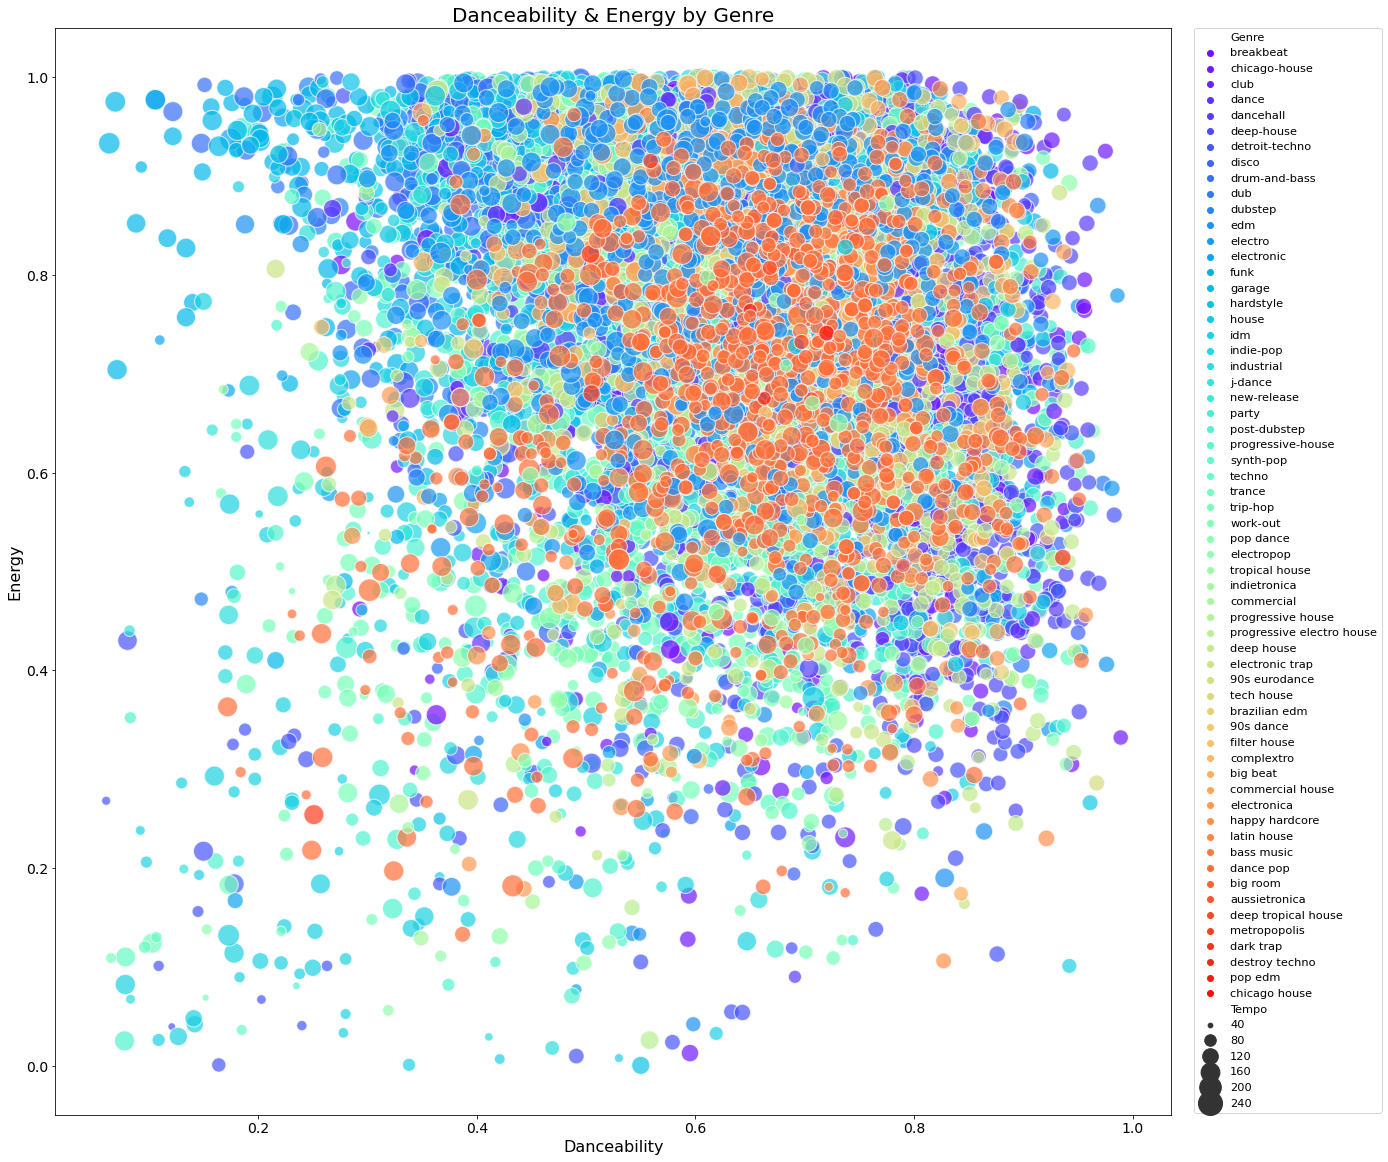

In [275]:
plt.figure(figsize=(20,20))

ax = sns.scatterplot(data=final_dataset, x='Danceability', y='Energy', 
                     hue='Genre', palette='rainbow',
                     size='Tempo', sizes=(10,600), 
                     alpha=0.7)

plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., fontsize=11.35)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Danceability', fontsize=16)
plt.ylabel('Energy', fontsize=16)
plt.title('Danceability & Energy by Genre', fontsize=20);